# Autoencoders
A notebook based on the [blog by Francois Chollet (2016)](https://blog.keras.io/building-autoencoders-in-keras.html). Readers are encouraged to read the detailed blog post describing what autoencoders are and what they're used for. I'll try to provide a brief summary here, along with my own comments. Images are mine.

## Introduction
Autoencoders are a class of *self-supervised* learning algorithm. It is self-supervised in a sense that the targets are generated from the input data. Its architecture forces the network to learn *features* from the inputs, and attempts to reconstruct the inputs using a decoding network.

In order to learn interesting features, we must come up with interesting loss functions. For example, merely trying to reconstruct every detail of an input image may not be conducive to the network learning interesting abstract features in our images. For this reason, reconstructions can be quite lossy, and that's ok.

But remember, just like other neural nets, the **features learned by autoencoders are specific to the data on which it was trained**.

### Applications of Autoencoders

* **Data Denoising**
* **Dimensionality reduction**: t-SNE is a great algorithm for visualizing relatively low-dimensional (e.g., $\mathbb{R}^{32}$) data in 2D. If your data has much more dimensions than that, then you can use autoencoders to "reduce" the dimensionality of your data first. Autoencoders can learn more interesting representations than PCA or other basic techniques.
* **Analysis of latent variables in a dataset** (see VAEs): If we're working with a dataset of faces, latent variables may represent skintone, gender, pose, illumination, etc. We can estimate the distribution of latent variables using autoencoders. If the distribution of a latent variable is skewed (or gaussian), then we can assume our input is not sufficiently diverse w.r.t. that attribute. To avoid bias, we should collect (or generate) a more balanced training dataset such that the distribution of that latent variable is more uniform.

# 1. The simplest of all autoencoders
<img src="AE_basic.jpg" width="650" />

In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

That's the basic encoder - two fully connected layers. Let's also create separate encoder and decoder models.

In [2]:
# Encoder = input -> encoder layer -> z
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# Decoder = z -> decoder layer -> reconstruction
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

We'll use the MNIST dataset in these examples. Luckily, they're included in the Keras package.

In [3]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)
print(np.max(x_train), np.min(x_train))

(60000, 28, 28)
(10000, 28, 28)
255 0


There are 60k training examples, 10k test examples, each are 28x28 images.

As always, normalize the data, and get it into the right shape.

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Let's train our autoencoder for 50 epochs. Here, we'll naively use a per-pixel binary crossentropy loss.

In [5]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 5ms/step - loss: 0.3841 - val_loss: 0.1903
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1797 - val_loss: 0.1532
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1487 - val_loss: 0.1339
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1319 - val_loss: 0.1216
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1206 - val_loss: 0.1132
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1129 - val_loss: 0.1071
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1074 - val_loss: 0.1028
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1032 - val_loss: 0.0996
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1003 - val_loss: 0.0972
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0980 - val_loss: 0.0957

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations.

In [6]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

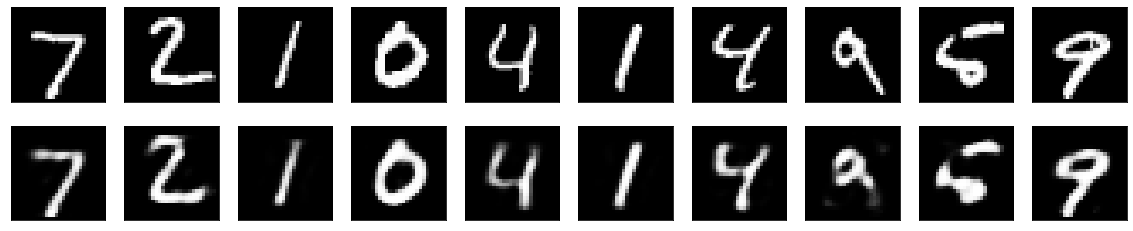

8.982427


In [7]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(encoded_imgs.mean())

# 2. Adding sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of [PCA (principal component analysis)](https://en.wikipedia.org/wiki/Principal_component_analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our `Dense` layer:

In [8]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). 

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 1s 4ms/step - loss: 0.3946 - val_loss: 0.1934
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1840 - val_loss: 0.1599
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1566 - val_loss: 0.1428
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1411 - val_loss: 0.1314
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1306 - val_loss: 0.1229
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1227 - val_loss: 0.1170
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1171 - val_loss: 0.1131
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1134 - val_loss: 0.1100
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1105 - val_loss: 0.1080
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1088 - val_lo

In [10]:
# Once again, explicitly define encoder and decoder, using the same code as above.
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [11]:
# Visualize the results
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

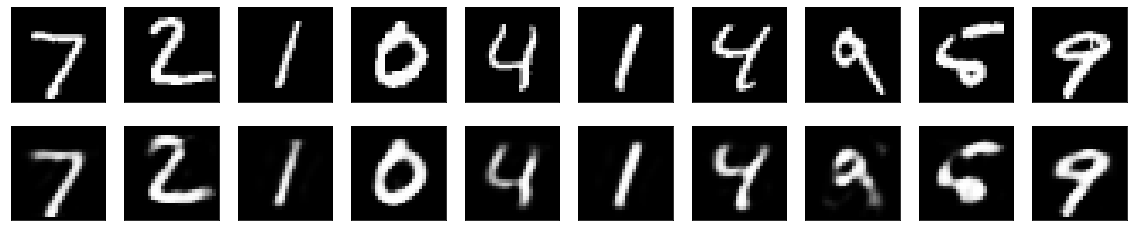

1.2718109


In [12]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print( encoded_imgs.mean() )

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 1.27 (over our 10,000 test images), whereas with the previous model the same quantity was 8.98. So our new model yields encoded representations that much more sparse.

# 3. Deep autoencoder
Let's make things more interesting, and build a 3-layer encoder followed by a 3-layer decoder

Input (784) -> Dense (128) -> Dense (64) -> Dense (32) -> Dense (64) -> Dense (128) -> Dense (784)

In [13]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [14]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 2s 6ms/step - loss: 0.3371 - val_loss: 0.1664
Epoch 2/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1587 - val_loss: 0.1362
Epoch 3/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1338 - val_loss: 0.1240
Epoch 4/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1242 - val_loss: 0.1173
Epoch 5/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1176 - val_loss: 0.1133
Epoch 6/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1136 - val_loss: 0.1096
Epoch 7/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1100 - val_loss: 0.1069
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1076 - val_loss: 0.1042
Epoch 9/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1051 - val_loss: 0.1021
Epoch 10/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1028 - val_lo

At 100 epochs of training, a deep network has a smaller loss than a shallow network.

# 4. Convolutional autoencoder
<img src="AE_conv.JPG"/>
Since our inputs are images, it makes sense to incorporate convnets in our encoder and decoder.
Our network will consist in a stack of `Conv2D` and `MaxPooling2D` layers, while the decoder will consist of a stack of `Conv2D` and `UpSampling2D` layers.

In [15]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [16]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Let's train this model for 50 epochs. This will take a minute. By that I mean ~30 minuts for me.

Francois uses the TensorBoard callback to monitor the training progress. I'll describe how to do that at the end of the notebook.

In [18]:
from keras.callbacks import TensorBoard

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 31s 67ms/step - loss: 0.1185 - val_loss: 0.1148
Epoch 2/50
469/469 [==============================] - 31s 66ms/step - loss: 0.1142 - val_loss: 0.1113
Epoch 3/50
469/469 [==============================] - 31s 67ms/step - loss: 0.1113 - val_loss: 0.1090
Epoch 4/50
469/469 [==============================] - 31s 67ms/step - loss: 0.1089 - val_loss: 0.1068
Epoch 5/50
469/469 [==============================] - 32s 68ms/step - loss: 0.1071 - val_loss: 0.1050
Epoch 6/50
469/469 [==============================] - 30s 65ms/step - loss: 0.1056 - val_loss: 0.1038
Epoch 7/50
469/469 [==============================] - 30s 64ms/step - loss: 0.1045 - val_loss: 0.1030
Epoch 8/50
469/469 [==============================] - 30s 64ms/step - loss: 0.1036 - val_loss: 0.1021
Epoch 9/50
469/469 [==============================] - 30s 64ms/step - loss: 0.1028 - val_loss: 0.1011
Epoch 10/50
469/469 [==============================] - 30s 64ms/step - loss: 0.102

In [20]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


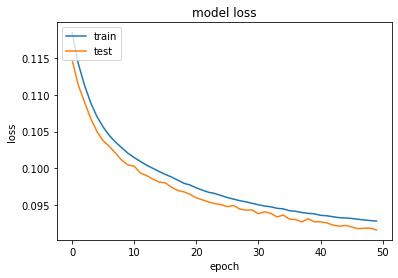

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In theory, the loss should be much less than our previous models. Since our loss from this convnet model is still about the same as previous models, we should maybe continue training until the loss plateaus.

# 5. Denoising
The idea here is to use training image + noise as the input, and clean trianing image as the output. The encoder should then learn the representations of our desired image.

In [23]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

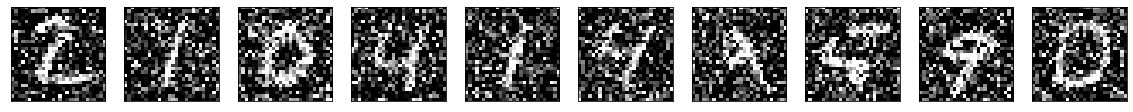

In [24]:
# some examples of noisy digits
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We'll use a convolutional autoencoder once again, with more filters per layer

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

We can train this for multiple epochs, but I won't do it here, since it will take ~30 minutes or so. Francois got it to work pretty well on his run.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Expected results
<img src="AE_denoised_digits.png"/>


# Wrapping Up
Here, we discussed autoencoders for dimensionality reduction and denoising. A more modern varient of the autoencoder is the variational autoencoder (VAEs). VAEs are popular generative models, which we'll talk about in the next set of notes.

In addition to autoencoders, we saw some new ways to interact with models in Keras:
* We defined autoencoders to be input -> encoder -> decoder -> output
* We can also define separate parts of the model as separate models, i.e.,
```
encoder = keras.Model(input_img, encoded)
...
encoded_input = keras.Input(shape=(encoding_dim,)) # encoded representations
decoder_layer = autoencoder.layers[-1] #final layer; decoded representations
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
```
* and run tensors through these models using `.predict()`
```
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
```

### Monitoring training progress:
We can use the TensorFlow backend and TensorBoard callback to monitor training progress.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.
```
    tensorboard --logdir=/tmp/autoencoder
```
Then, train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to `tmp/autoencoder` which can be read by our TensorBoard server. This allows us to monitor training in the TensorBoard web interface (by navighating to localhost:6006)

The callback is passed as a parameter in `.fit()`:
```
    history = autoencoder.fit(x_train, x_train,
                            epochs=50,
                            batch_size=128,
                            shuffle=True,
                            validation_data=(x_test, x_test),
                            callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
```